In [1]:
using QuantumBayesian
using PyPlot

# Deterministic Single Qubit Evolution Tests

**Justin Dressel**, 12/6/2016

## Basic Definitions

### Qubit Hilbert space

In [2]:
q = qubit()

QuantumBayesian.QFactor: Qubit
Dims  : 2
Ops   : "d", "y", "x", "u", "z", "i"


### Global Constants

In [3]:
Ω  = 2*π;        # Rabi frequency
τ = 3.0;         # Measurement collapse timescale
η = 1.0;         # Measurement efficiency
Γ = 1/(2*τ*η);   # Measurement dephasing rate
T = (0.0, 6*τ);  # Time duration of simulation;

dt = 1e-2;       # Simulation timestep (coarse to show method precision);

### Common Trajectory and Plotting Code

In [4]:
# Initial conditions (matrix and superket)
init = ground(q)
sinit = sparse(superket(init))

# Bloch expectation values (matrix and superket)
fs  = collect(ρ -> real(expect(ρ, q(l)))    for l in ["x","y","z"])
sfs = collect(ρ -> real(ρ ⋅ superket(q(l))) for l in ["x","y","z"])

# Trajectory and plotting function
function solve(inc, init, dt, T, fs, plot_title)
    @time out = trajectory(inc, init, T, fs..., dt=dt)
    p = plot(out[1],out[2],label=L"$x$")
    hold(true)
    plot(out[1],out[3],label=L"$y$")
    plot(out[1],out[4],label=L"$z$")
    ax = gca()
    ax[:set_ylim]([-1.1,1.1])
    xlabel(L"$t (2\pi/\Omega)$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    hold(false)
    show()
end;

## Time-independent Rabi Hamiltonian

In [5]:
# Hamiltonian
H = (Ω/2)*q("y");
# Measurement dephasing
DM = sqrt(Γ/2)*q("z");

### Coherent (Hamiltonian) Evolution

  0.629916 seconds

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.034956671 s, Steps per second: 51463.710603335196


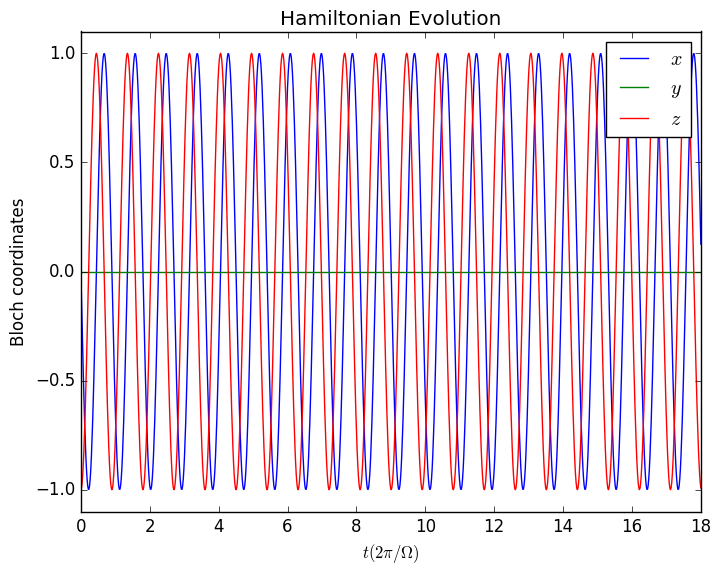

 (804.09 k allocations: 37.383 MB, 1.76% gc time)


In [6]:
solve(ham(dt, H), init, dt, T, fs, "Hamiltonian Evolution")

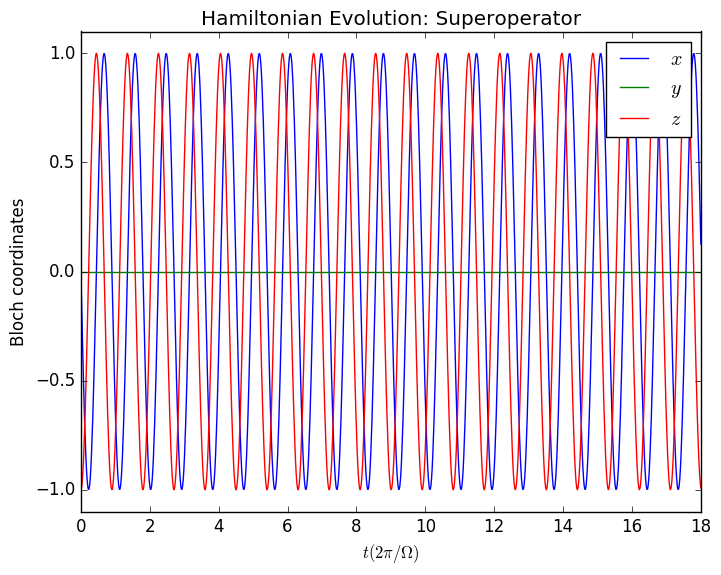

  1.337123 seconds (2.00 M allocations: 49.474 MB, 0.82% gc time)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.074969868 s, Steps per second: 23996.307423136986


In [7]:
solve(sham(dt, H), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

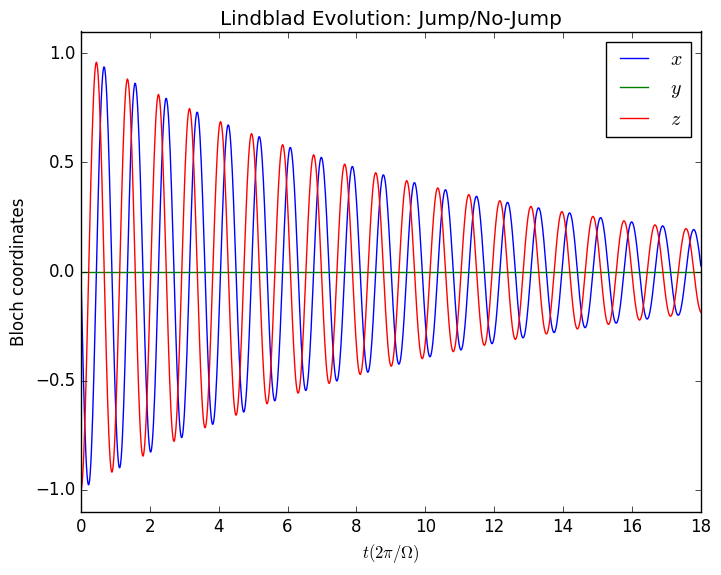

  0.123751 seconds (327.55 k allocations: 23.245 MB, 3.21% gc time)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.090866771 s, Steps per second: 19798.21644592169


In [8]:
solve(lind(dt, H, DM), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

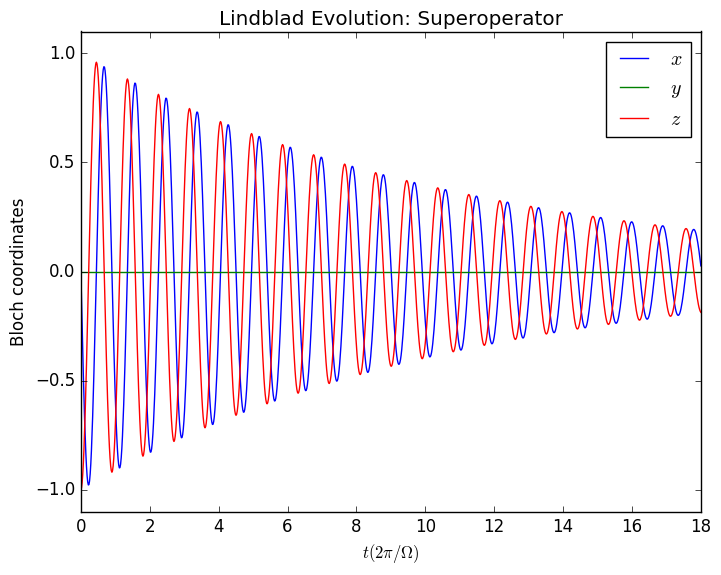

  0.147644 seconds (143.81 k allocations: 8.513 MB, 3.92% gc time)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.09780416 s, Steps per second: 18393.90062753977


In [9]:
solve(slind(dt, H, DM), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.681163556 s, Steps per second: 2641.069070935439


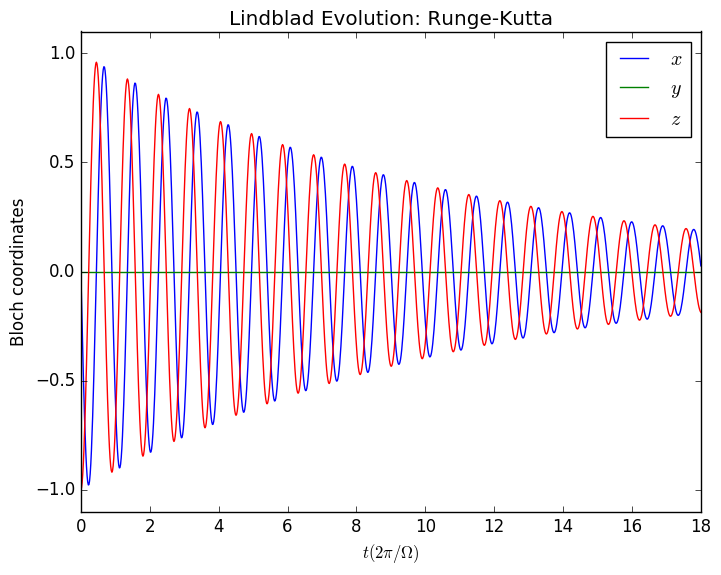

  0.769265 seconds (2.63 M allocations: 180.881 MB, 3.36% gc time)


In [10]:
solve(lind_rk4(dt, H, DM), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

## Time-dependent Rabi Pulse

In [11]:
# Hamiltonian
f(t::Float64) = 2*exp(-(t-3*τ)^2/2)/sqrt(2π)
h(t::Float64) = f(t)*(Ω/2)*q("y");

### Coherent (Hamiltonian) Evolution

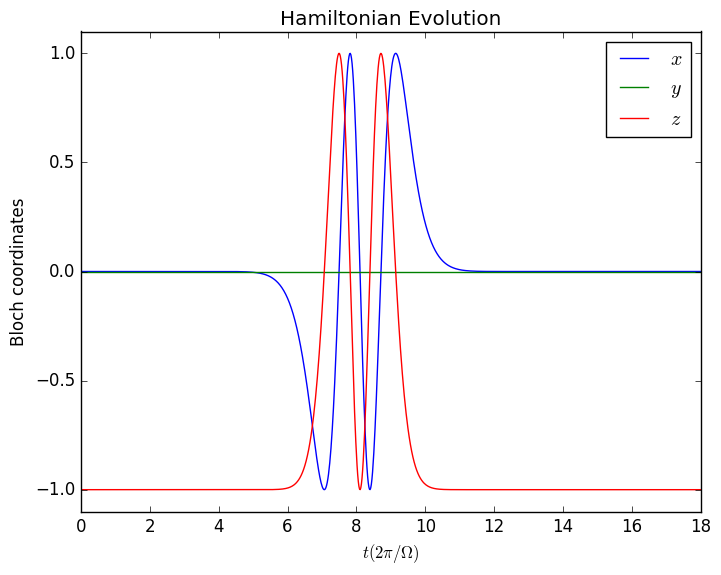

  0.177388 seconds (340.42 k allocations: 21.843 MB, 2.24% gc time)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.060797491 s, Steps per second: 29590.03686517261


In [12]:
solve(ham(dt, h), init, dt, T, fs, "Hamiltonian Evolution")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.490142397 s, Steps per second: 3670.361941776687


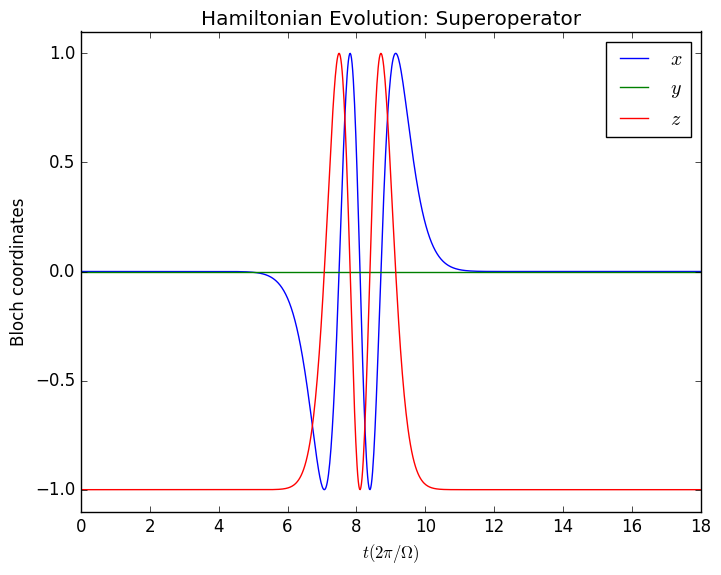

  0.722551 seconds (482.06 k allocations: 32.359 MB, 3.11% gc time)


In [13]:
solve(sham(dt, h), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.086969712 s, Steps per second: 20685.362278766657


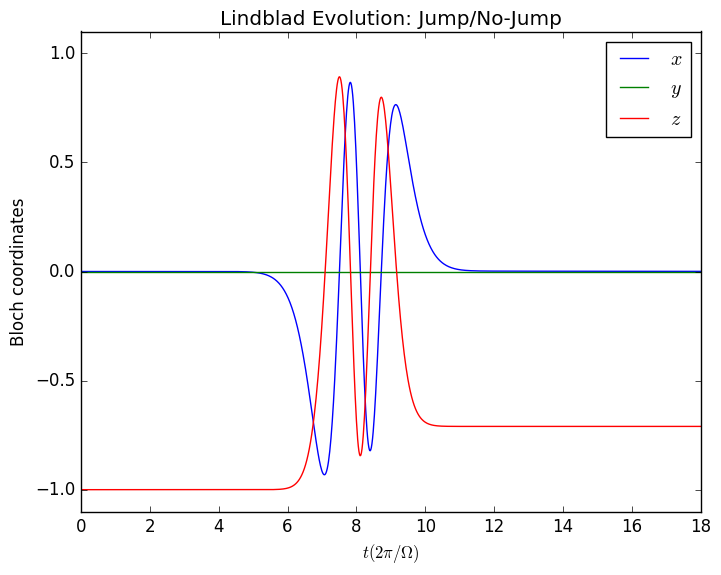

  0.124960 seconds (447.20 k allocations: 32.504 MB, 2.89% gc time)


In [14]:
solve(lind(dt, h, DM), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.463360234 s, Steps per second: 3882.508398422468


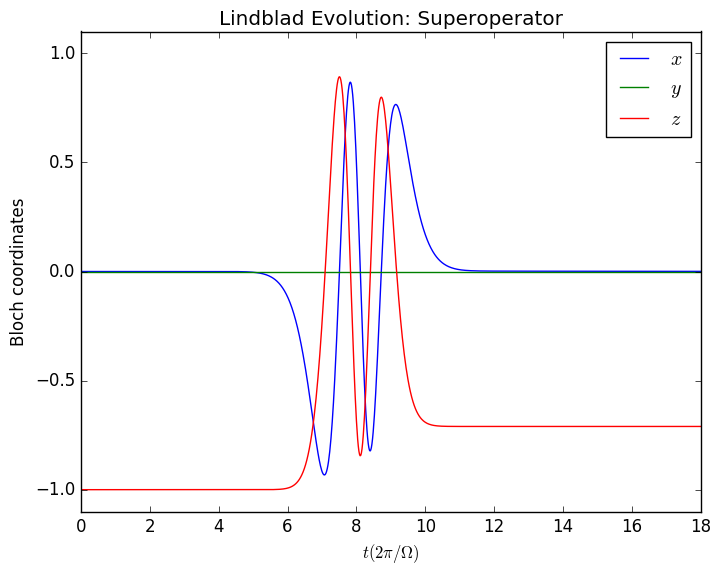

  0.506006 seconds (930.15 k allocations: 71.637 MB, 3.21% gc time)


In [15]:
solve(slind(dt, h, DM), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.844401938 s, Steps per second: 2130.50197902317


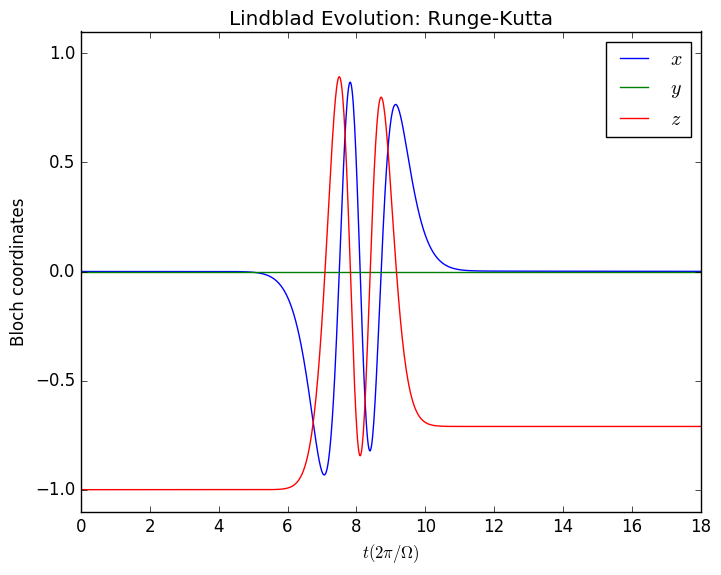

  1.116848 seconds (3.09 M allocations: 199.179 MB, 2.77% gc time)


In [16]:
solve(lind_rk4(dt, h, DM), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

## Version Information

In [17]:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i7-6560U CPU @ 2.20GHz
  WORD_SIZE: 64
  BLAS: libopenblas (NO_LAPACKE DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: liblapack.so.3
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, broadwell)


In [18]:
Pkg.installed("PyPlot")

v"2.2.4"

In [19]:
Pkg.installed("QuantumBayesian")

v"0.0.0-"